In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
from keras.layers import Conv1D, RNN, Embedding, SimpleRNN, Dense

from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Attention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

In [ ]:
data = pd.read_csv(r'../data-files/processed_data.csv')
data

,target,text
0,0,awww that's bummer. shoulda got david carr day...
1,0,upset can't update facebook texting it... resu...
2,0,dived times ball. managed save 50 rest bounds
3,0,body feels itchy like
4,0,it's behaving all. i'm mad. can't there.
...,...,...
1599995,4,woke up. having school best feeling
1599996,4,thewdb.com cool hear old walt interviews
1599997,4,ready mojo makeover ask details
1599998,4,happy 38th birthday boo alll tears eyes tupac ...


In [3]:
data = shuffle(data, random_state=42).reset_index(drop=True)
data['target'] = data['target'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
X = data['text'].tolist()
Y = data['target'].tolist()
Y

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
X_train = [str(text) for text in X_train if isinstance(text, (str, float))]
X_test = [str(text) for text in X_test if isinstance(text, (str, float))]

In [7]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [8]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [9]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

322144

In [10]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [12]:
embeddings_dictionary = dict()
glove_file = open('../a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [13]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(322144, 100)

In [ ]:
type(embedding_matrix)
np.savetxt('embedding_matrix_lstm.csv', embedding_matrix, delimiter=',')

----------
SAVED
_________

In [ ]:
loaded_embedding_matrix = np.loadtxt('embedding_matrix_lstm.csv', delimiter=',')

In [14]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [15]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          32214400  
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 32,224,401
Trainable params: 10,001
Non-trainable params: 32,214,400
_________________________________________________________________
None


In [16]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8000/8000 [==============================] - 26s 3ms/step - loss: 0.5938 - acc: 0.6858 - val_loss: 0.5893 - val_acc: 0.6923
Epoch 2/6
8000/8000 [==============================] - 26s 3ms/step - loss: 0.5903 - acc: 0.6899 - val_loss: 0.5898 - val_acc: 0.6912
Epoch 3/6
8000/8000 [==============================] - 26s 3ms/step - loss: 0.5901 - acc: 0.6898 - val_loss: 0.5903 - val_acc: 0.6912
Epoch 4/6
8000/8000 [==============================] - 26s 3ms/step - loss: 0.5902 - acc: 0.6903 - val_loss: 0.5892 - val_acc: 0.6919
Epoch 5/6
8000/8000 [==============================] - 25s 3ms/step - loss: 0.5901 - acc: 0.6901 - val_loss: 0.5920 - val_acc: 0.6902
Epoch 6/6
8000/8000 [==============================] - 25s 3ms/step - loss: 0.5901 - acc: 0.6902 - val_loss: 0.5900 - val_acc: 0.6911


In [17]:
score = snn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10000/10000 [==============================] - 14s 1ms/step - loss: 0.5899 - acc: 0.6902
Test Score: 0.5898541212081909
Test Accuracy: 0.690165638923645


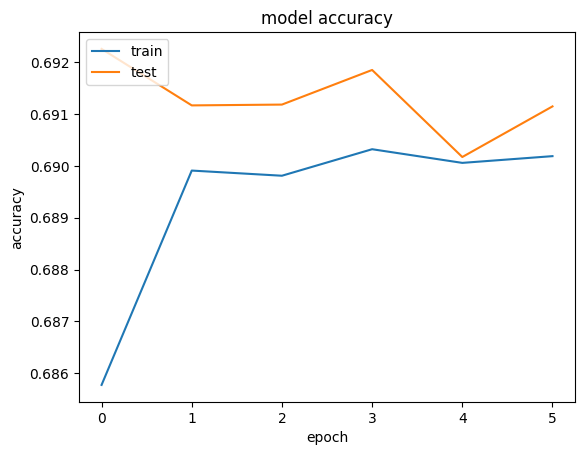

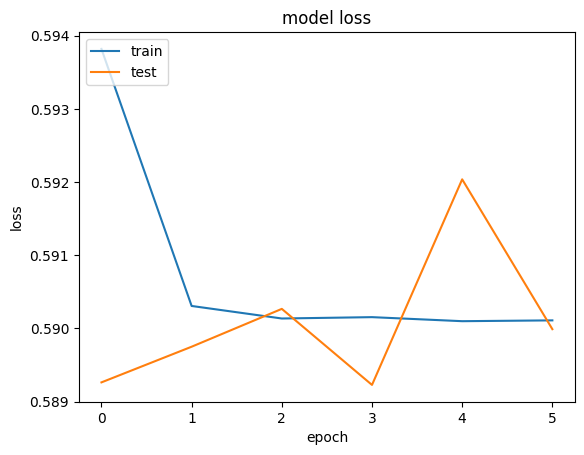

In [18]:

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [19]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [20]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          32214400  
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 32,278,657
Trainable params: 64,257
Non-trainable params: 32,214,400
_________________________________________________________________
None


In [21]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8000/8000 [==============================] - 160s 20ms/step - loss: 0.5214 - acc: 0.7376 - val_loss: 0.5148 - val_acc: 0.7422
Epoch 2/6
8000/8000 [==============================] - 162s 20ms/step - loss: 0.4956 - acc: 0.7562 - val_loss: 0.5019 - val_acc: 0.7520
Epoch 3/6
8000/8000 [==============================] - 164s 20ms/step - loss: 0.4848 - acc: 0.7635 - val_loss: 0.4973 - val_acc: 0.7548
Epoch 4/6
8000/8000 [==============================] - 163s 20ms/step - loss: 0.4771 - acc: 0.7689 - val_loss: 0.4972 - val_acc: 0.7558
Epoch 5/6
8000/8000 [==============================] - 163s 20ms/step - loss: 0.4708 - acc: 0.7728 - val_loss: 0.4965 - val_acc: 0.7558
Epoch 6/6
8000/8000 [==============================] - 164s 20ms/step - loss: 0.4659 - acc: 0.7760 - val_loss: 0.4970 - val_acc: 0.7567


In [22]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5898541212081909
Test Accuracy: 0.690165638923645


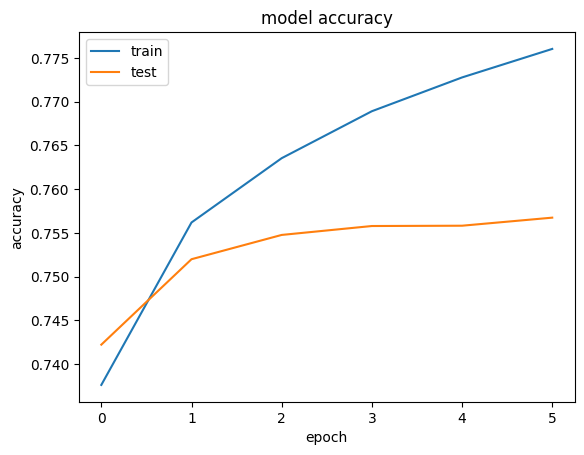

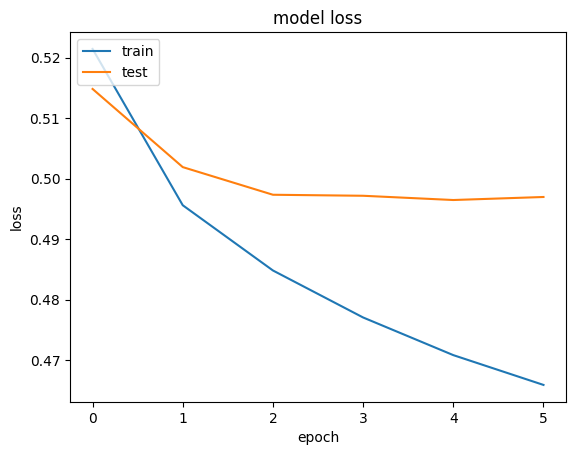

In [23]:
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [24]:
rnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
rnn_model.add(embedding_layer)

rnn_model.add(SimpleRNN(128))

rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          32214400  
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 32,243,841
Trainable params: 29,441
Non-trainable params: 32,214,400
_________________________________________________________________


In [25]:
rnn_model_history = rnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8000/8000 [==============================] - 280s 35ms/step - loss: 0.6938 - accuracy: 0.5035 - val_loss: 0.6931 - val_accuracy: 0.4993
Epoch 2/6
8000/8000 [==============================] - 296s 37ms/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5016
Epoch 3/6
8000/8000 [==============================] - 290s 36ms/step - loss: 0.6942 - accuracy: 0.5007 - val_loss: 0.7002 - val_accuracy: 0.5021
Epoch 4/6
8000/8000 [==============================] - 306s 38ms/step - loss: 0.6943 - accuracy: 0.5004 - val_loss: 0.6942 - val_accuracy: 0.5017
Epoch 5/6
8000/8000 [==============================] - 303s 38ms/step - loss: 0.6942 - accuracy: 0.5010 - val_loss: 0.6936 - val_accuracy: 0.5011
Epoch 6/6
8000/8000 [==============================] - 304s 38ms/step - loss: 0.6944 - accuracy: 0.5014 - val_loss: 0.6957 - val_accuracy: 0.4969


In [26]:
score = rnn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10000/10000 [==============================] - 63s 6ms/step - loss: 0.6956 - accuracy: 0.4972
Test Score: 0.6956378221511841
Test Accuracy: 0.49716874957084656


In [ ]:
lstm_model = Sequential()

# Embedding layer (use pre-trained embeddings like GloVe or FastText, fine-tune during training)
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
lstm_model.add(embedding_layer)

# Bidirectional LSTM Layer (captures context from both ends of the sentence)
lstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))

# Attention Layer (self-attention)
# Pass the same tensor as both query and value
attention_output = Attention()([lstm_model.output, lstm_model.output])

# Global Average Pooling to reduce the output dimensionality
lstm_model.add(GlobalAveragePooling1D())

# Dropout Layer (regularization to prevent overfitting)
lstm_model.add(Dropout(0.5))

# Dense Layer (final classification layer)
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
lstm_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model.summary())

In [ ]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
print()

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Attention, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    # Define the model architecture
    lstm_model = Sequential()

    # Embedding layer (use pre-trained embeddings like GloVe or FastText, fine-tune during training)
    embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
    lstm_model.add(embedding_layer)

    # Bidirectional LSTM Layer (captures context from both ends of the sentence)
    lstm_model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units', min_value=128, max_value=240, step=32), 
        return_sequences=True)))

    # Attention Layer (self-attention)
    attention_output = Attention()([lstm_model.output, lstm_model.output])

    # Global Average Pooling to reduce the output dimensionality
    lstm_model.add(GlobalAveragePooling1D())

    # Dropout Layer (regularization to prevent overfitting)
    lstm_model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)))

    # Dense Layer (final classification layer)
    lstm_model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=180, step=32),
        activation='relu'))
    lstm_model.add(Dropout(rate=hp.Float('dropout_rate_2', min_value=0.2, max_value=0.7, step=0.1)))
    lstm_model.add(Dense(1, activation='sigmoid'))

    # Compile the model with an optimizer
    lstm_model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',  # Use binary crossentropy for binary classification tasks
        metrics=['accuracy']
    )

    return lstm_model

# Define the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='accuracy',
    max_trials=10,  # Number of trials to run
    executions_per_trial=1,  # Run each trial once
    directory='my_dir_2',  # Save results here
    project_name='lstm_bayesian_tuning_2'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=2)

# Get the best hyperparameterss
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hp.values}")


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('best_lstm_model_new.h5')

Best Hyperparameters: {'lstm_units': 192, 'dropout_rate': 0.5, 'dense_units': 128, 'dropout_rate_2': 0.30000000000000004, 'learning_rate': 0.0010872353209015178}

In [ ]:
from ibm_watson_machine_learning import APIClient
import json
import numpy as np

In [ ]:
wml_creds ={
    "apikey": '_KnZKtXJvhFYIq2z5Ot08WKKpfBwbsgyj3CWsxYHJyds',
    "url": "https://us-south.ml.cloud.ibm.com"
}

In [ ]:
wml_client = APIClient(wml_credentials=wml_creds)
wml_client.spaces.list()

In [ ]:
SPACE_ID ='6760b3b6-140d-46c0-861e-2eebda2dd6ab'
wml_client.set.default_space(SPACE_ID)
print(f"Default space is set to: {SPACE_ID}")

In [ ]:
# Set Python Version and Runtime for TensorFlow
software_spec_uid = wml_client.software_specifications.get_id_by_name('tensorflow_rt23.1-py3.10')

# # Setup model meta for custom TensorFlow model
# model_props = {
#     wml_client.repository.ModelMetaNames.NAME: 'FastBert Model', 
#     wml_client.repository.ModelMetaNames.TYPE: 'tensorflow_2.12',
#     wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
# }
model_dir = 'best_lstm_model.zip'

# Define the location of requirements.txt
requirements_file = 'requirement.txt'

# Define the location of pipeline.py
pipeline_file = 'lstm_pipeline.py'

# Create the client to interact with WML

# Upload the model
model_metadata = {
    wml_client.repository.ModelMetaNames.NAME: "Best_82",
    wml_client.repository.ModelMetaNames.TYPE: "tensorflow_2.12",
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

# Store the model
model_uid = wml_client.repository.store_model(model = model_dir, meta_props=model_metadata)

# Print model UID
print(f"Model uploaded with UID: {model_uid}")

In [ ]:
# model_details = wml_client.repository.store_model(
#     model='model_package',  # Path to the zip file
#     meta_props=model_props
# )
# model_details

model_uid = model_uid['metadata']['id']

deployment_props = {
    wml_client.deployments.ConfigurationMetaNames.NAME: 'FEMA-SentimentAnalysis',
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {
        "dependencies": {
            "pip_requirements": requirements_file,  # Point to the requirements file
            "python": "3.10"  # Ensure the Python version is appropriate
        },
        "pipeline": pipeline_file  # Ensure the pipeline file is used for inference
    }
}

# Deploy the model
deployment = wml_client.deployments.create(
    artifact_uid=model_uid,
    meta_props=deployment_props
)

# Output result
print(f"Deployment created: {deployment}")



In [ ]:
input_text = {
    "input_data": [
        {
            "fields": ["text"],  # Name of the input field (this should match what the model expects)
            "values": [["This is a sample text to analyze."]]  # List of texts you want to predict on
        }
    ]
}


In [ ]:
import json
import requests

# 1. Get the Deployment ID and Scoring URL from the deployment response
deployment_uid = deployment['metadata']['id']
deployment_url = deployment['entity']['status']['inference'][0]['url']  # Correct scoring URL

# Set the version query parameter (you should use the correct version date)
version = "2021-06-28"  # Replace this with the version of the Watson API you're using

# 2. Prepare the input data (text)
input_text = {
    "input_data": [
        {
            "fields": ["text"],  # Input field name as expected by the model
            "values": [["This is a test sentence for sentiment analysis."]]  # Example text for prediction
        }
    ]
}

# 3. Prepare the headers for authentication and API version
headers = {
    "Authorization": "_KnZKtXJvhFYIq2z5Ot08WKKpfBwbsgyj3CWsxYHJyds",  # Replace with your IBM Cloud API key
    "Content-Type": "application/json"
}

# Add version to the scoring URL as a query parameter
scoring_url_with_version = f"{deployment_url}?version={version}"

# 4. Send the scoring request via the correct URL (use requests library instead)
response = requests.post(scoring_url_with_version, headers=headers, data=json.dumps(input_text))

# 5. Handle the response and print the prediction
if response.status_code == 200:
    prediction = response.json()
    print(f"Prediction: {prediction}")
else:
    print(f"Failed to get prediction. Status Code: {response.status_code}")
    print(f"Response: {response.text}")


In [ ]:
deployment_uid

In [ ]:
X_test[0].shape

In [ ]:
payload = {
    "input_data": [
        {
            "fields": ["embedding_input"],  # Rename to match the model's expected field name for embeddings
            "values": [X_test[0].tolist()]  # Convert numpy array to list if needed
        }
    ]
}

In [ ]:
result = wml_client.deployments.score(deployment_uid, payload)

In [ ]:
y_test[0]

In [ ]:
result

In [ ]:
# Adjust the payload to pass raw text if the pipeline handles embedding
payload = {
    "input_data": [
        {
            "fields": ["text"],  # Assuming the pipeline expects 'text' as input field
            "values": [["This is a test sentence for sentiment analysis."]]  # Raw text
        }
    ]
}

# Perform the inference
result = wml_client.deployments.score(deployment_uid, payload)

# Output the result
print(result)


In [ ]:
X_test[0]

In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-11-25 11:06:25.962760: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:


# Step 1: Load the embedding matrix (optional if you're not retraining)
embedding_matrix = np.load('../embedding_matrix_lstm.npy')

# Step 2: Load the trained model
model = load_model('best_lstm_model.h5')

# Step 3: Recreate or load the tokenizer (use the same tokenizer as during training)
# If saved as a pickle file:
import pickle
with open('../word_tokenizer_lstm.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [9]:


# Step 4: Preprocess the new text
max_sequence_length = embedding_matrix.shape[1]  # Ensure this matches your training config
new_text = "You are stupid!!!!"
sequence = tokenizer.texts_to_sequences([new_text])
padded_sequence = pad_sequences(sequence, padding='post', maxlen=max_sequence_length)

# Step 5: Make predictions
prediction = model.predict(padded_sequence)
print("Prediction:", prediction)


1/1 [==============================] - 0s 42ms/step
Prediction: [[0.34542564]]
